In [ ]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.attn_features_artifact import AttentionFeaturesArtifact
from math import sqrt
from text3d2video.attention_visualization import split_heads
import text3d2video.wandb_util as wbu

from einops import rearrange

artifact_tag = "attn_data:latest"
attn_data = AttentionFeaturesArtifact.from_wandb_artifact_tag(
    artifact_tag, download=True
)

In [ ]:
from omegaconf import OmegaConf

from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

run = attn_data.logged_by()
run_config = OmegaConf.create(run.config)

n_frames = run_config.animation.n_frames
anim = wbu.first_used_artifact_of_type(run, 'animation')
anim = AnimationArtifact.from_wandb_artifact(anim)

frame_nums = anim.frame_nums(n_frames)
cameras = anim.cameras(frame_nums)
meshes = anim.load_frames(frame_nums)

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps)

In [ ]:
# read data
multidict = attn_data.get_features_diskdict()
images = attn_data.get_images()
layer_names = sorted(multidict.key_values("layer"))
time_steps = sorted(multidict.key_values("timestep"))

for layer in layer_names:
    print(layer)

In [50]:
layer_name = layer_names[3]
time_step = time_steps[-1]
print(time_step)

identifier = {"layer": layer_name, "timestep": time_step}

print(identifier)

# get queries keys and values
x = multidict[identifier | {"name": "x"}][: len(images)]
qrys = multidict[identifier | {"name": "query"}][: len(images)]
keys = multidict[identifier | {"name": "key"}][: len(images)]
vals = multidict[identifier | {"name": "value"}][: len(images)]

layer_res = int(sqrt(qrys.shape[1]))

# reshape q/k/v to b t h w d
qrys_multihead = split_heads(qrys)
keys_multihead = split_heads(keys)
vals_multihead = split_heads(vals)

9
{'layer': 'down_blocks.1.attentions.1.transformer_blocks.0.attn1', 'timestep': '9'}


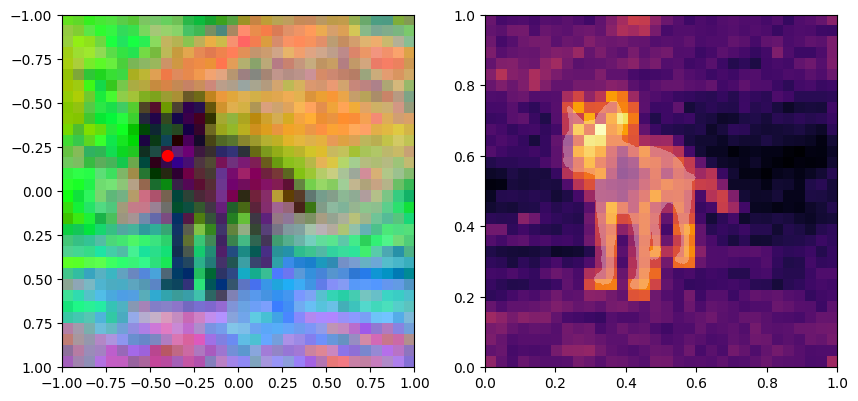

In [51]:
from matplotlib.colors import ListedColormap
from text3d2video.feature_visualization import reduce_feature_map
from text3d2video.util import sample_feature_map
from torch import Tensor
from einops import einsum
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch.nn.functional as F

head_idx = 0
frame_idx = 1

pixel_coord = Tensor([-0.4, -0.2])

# get query, key, value for head
head_qrys = qrys_multihead[:, :, head_idx, :]
head_keys = keys_multihead[:, :, head_idx, :]
head_vals = vals_multihead[:, :, head_idx, :]

# reshape query
q_square = rearrange(head_qrys[frame_idx], "(h w) d -> d h w", h=layer_res)
k_square = rearrange(head_keys[frame_idx], "(h w) d -> d h w", h=layer_res)

# get query feature
pixel_qry = sample_feature_map(q_square, pixel_coord.unsqueeze(0), mode="nearest")[0]

similarities = einsum(pixel_qry, k_square, "d, d h w -> h w")
similarities = F.softmax(similarities / (10 * sqrt(q_square.shape[0])), dim=-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_q = axs[0]
ax_sim = axs[1]

ax_q.imshow(reduce_feature_map(q_square), extent=[-1,1,1,-1])
# add marker on qry axis
patch = Circle(pixel_coord, 0.03, color="red")
ax_q.add_patch(patch)


ax_sim.imshow(similarities.detach().numpy(), extent=[0,1,0,1], alpha=1, cmap="inferno")

transparent_cmap = ListedColormap(['none'] + ['white'] * 5)
ax_sim.imshow(depth_maps[frame_idx], extent=[0,1,0,1], cmap=transparent_cmap, alpha=0.3)

In [250]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

q_square_rgb = reduce_feature_map(q_square, output_type=".pt").permute(1, 2, 0)
print(q_square_rgb.shape)

fig = make_subplots(rows=1, cols=2, shared_yaxes=True, shared_xaxes=True)


def heatmap(z):
    fig = px.imshow(
        z,
        binary_string=False,
    )
    
    trace = fig.data[0]
    return trace


fig.add_trace(heatmap(q_square_rgb), col=1, row=1)
fig.add_trace(heatmap(similarities), col=2, row=1)

fig.update_xaxes(range=[0, False], scaleanchor="y", constrain="domain")
fig.update_yaxes(range=[0, 1], autorange="reversed")

pixel_coord = Tensor([10, 10]).int()

fig.add_trace(
    go.Scatter(
        x=[pixel_coord[0]],
        y=[pixel_coord[1]],
        mode="markers",
        marker=dict(size=10, color="red"),
        name="query",
    )
)

margin = 20

fig.update_layout(margin=dict(l=margin, r=margin, t=margin, b=margin), dragmode="pan")


config = {
    # "scrollZoom": True,
}
fig.show(config=config)

torch.Size([32, 32, 3])
